In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
import numpy as np
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.extensions import RXGate, RZGate
from qiskit.circuit import QuantumRegister,ClassicalRegister
from qiskit import  execute, BasicAer
import qiskit.quantum_info as qi
import scipy.optimize 
import random
import matplotlib.pyplot as plt
import pickle
import os 
import h5py 
import pandas as pd
import uproot
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import time


from qiskit.primitives import Sampler
from qiskit.circuit.library import ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA
from IPython.display import clear_output
from qiskit import  execute, BasicAer
from qiskit_machine_learning.circuit.library import RawFeatureVector

from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.circuit.library import RealAmplitudes,EfficientSU2
from sklearn.utils import shuffle
import pandas as pd

from sklearn import metrics
from sklearn.metrics import RocCurveDisplay


In [2]:
Iter="0"
MaxIter=60
method='COBYLA'
maxEvents=1000

In [3]:
def callback_graph(weights, obj_func_eval):
    print(len(objective_func_vals))
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
    
def produceDataset(inputFileName,path,treeName):
    
    print("start preparing",inputFileName)
    file = uproot.open(path+inputFileName+".root")
    tree=file[treeName]
    VariableList=tree.keys()
    

    df = tree.arrays(filter_name=VariableList[0],library="pd") 
    for i in range(1,len(VariableList)):
        df=df.join(tree.arrays(filter_name=VariableList[i],library="pd"))



    return df

def getFourVector(pt,eta,phi):
   
    m=1 # precision issues. not sure why but m=1 makes that no negative invariant mass square.
    px=pt*np.cos(phi)
    py=pt*np.sin(phi)
    pz=pt*np.sinh(eta)
    E=np.sqrt(px**2+py**2+pz**2+m**2)
    return np.array([E,px,py,pz], dtype=np.float64)

def getInvM(v):
    m2=v[0]**2-v[1]**2-v[2]**2-v[3]**2
    
    return np.sqrt(m2)

def getMass(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    v=v1+v2+v3+v4
    m_reco=getInvM(v)
    return m_reco

def getThreeVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    output=np.concatenate([v1[1:],v2[1:],v3[1:],v4[1:]])
    return  np.transpose(output)

def getFourVectors_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    output=np.concatenate([v1,v2,v3,v4])
    return  np.transpose(output)


def getDot_df(df):
    v1=getFourVector(df['f_lept1_pt'],df['f_lept1_eta'],df['f_lept1_phi'])
    v2=getFourVector(df['f_lept2_pt'],df['f_lept2_eta'],df['f_lept2_phi'])
    v3=getFourVector(df['f_lept3_pt'],df['f_lept3_eta'],df['f_lept3_phi'])
    v4=getFourVector(df['f_lept4_pt'],df['f_lept4_eta'],df['f_lept4_phi'])
    
    dot=[]

#     dot.append(getInvM(v1+v1))
#     dot.append(getInvM(v2+v2))
#     dot.append(getInvM(v3+v3))
#     dot.append(getInvM(v4+v4))
    
    dot.append(getInvM(v1+v2))
    dot.append(getInvM(v1+v3))
    dot.append(getInvM(v1+v4))
    dot.append(getInvM(v2+v3))
    dot.append(getInvM(v2+v4))
    dot.append(getInvM(v3+v4))
    dot=np.array(dot)
    

    return np.transpose(dot)
    

In [4]:

nShots=2**12

maxDatasetEvents=5000

Dir="/Users/lizhelun/Desktop/QC/Datasets/"

h4l_VV="ntuple_4mu_VV"
h4l_bkg="ntuple_4mu_bkg"

print("nShots = ",nShots)

nShots =  4096


In [5]:
h4l=produceDataset(h4l_VV,Dir,'HZZ4LeptonsAnalysisReduced')
bkg=produceDataset(h4l_bkg,Dir,'HZZ4LeptonsAnalysisReduced')

start preparing ntuple_4mu_VV
start preparing ntuple_4mu_bkg


In [6]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

<Figure size 432x288 with 0 Axes>

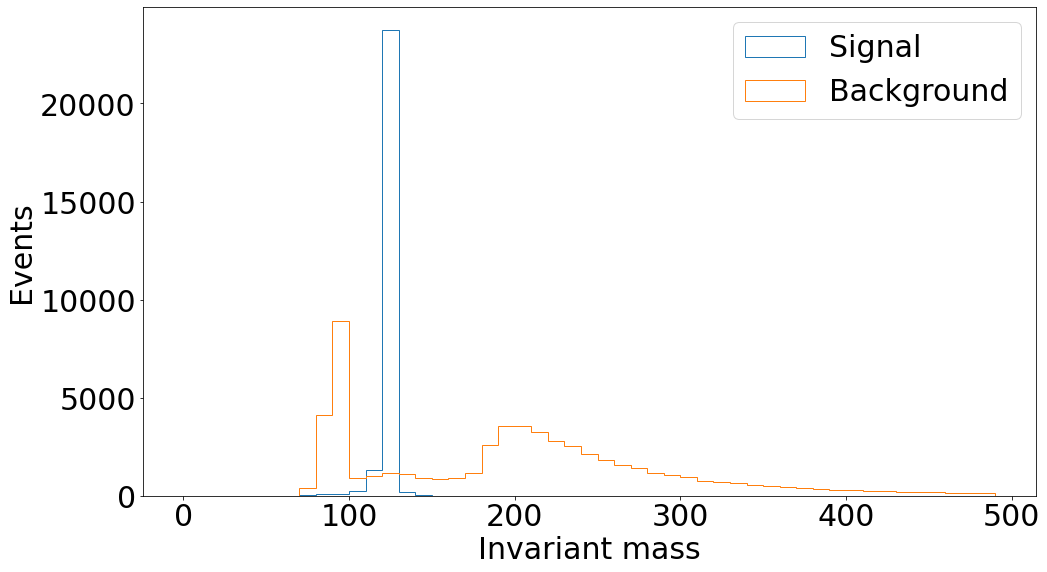

In [7]:
m_reco_signal=getMass(h4l)
m_reco_bkg=getMass(bkg)

LabelSize=30
plt.figure(1)
plt.figure(figsize=(16,9))
plt.hist(m_reco_signal,bins=np.arange(0,500,10),histtype='step',label='Signal');
plt.hist(m_reco_bkg,bins=np.arange(0,500,10),histtype='step',label='Background');

plt.xlabel('Invariant mass',fontsize=LabelSize)
plt.ylabel('Events',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize)

In [8]:
sig_3vec=getThreeVectors_df(h4l)
bkg_3vec=getThreeVectors_df(bkg)

In [9]:
sig_4vec=getFourVectors_df(h4l)
bkg_4vec=getFourVectors_df(bkg)

In [10]:
sig_dot=getDot_df(h4l)
bkg_dot=getDot_df(bkg)

In [11]:
random_state=int(1000*np.random.rand())
print(random_state)

def split(X,y,normalize=True,random_state=random_state):
    train_ratio=0.6
    X_train, X_valTest, y_train, y_valTest = train_test_split(X.copy(), y.copy(), train_size=train_ratio, random_state=100)
    X_val, X_test, y_val, y_test = train_test_split(X_valTest, y_valTest, test_size=0.5, random_state=random_state)
    #Normalizing everythings:
    if normalize:
        Max=X_train.max()
        X_train=np.pi*2*X_train/Max
        X_val=np.pi*2*X_val/Max
        X_test=np.pi*2*X_test/Max
        
    
    return X_train,y_train,X_val,y_val,X_test,y_test

198


In [12]:
X_mass=np.concatenate([m_reco_signal[0:maxDatasetEvents],m_reco_bkg[0:maxDatasetEvents]])
y_mass=np.concatenate([np.ones(m_reco_signal[0:maxDatasetEvents].shape[0]),-1*np.ones(m_reco_signal[0:maxDatasetEvents].shape[0])])
X_mass,y_mass=shuffle(X_mass,y_mass,random_state=random_state)
X_train_mass,y_train_mass,X_val_mass,y_val_mass,X_test_mass,y_test_mass=split(X_mass,y_mass,normalize=False)

In [13]:
X_3=np.concatenate([sig_3vec[0:maxDatasetEvents],bkg_3vec[0:maxDatasetEvents]])
y_3=np.concatenate([np.ones(sig_3vec[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_3vec[0:maxDatasetEvents].shape[0])])
X_3,y_3=shuffle(X_3,y_3,random_state=random_state)

X_train_3,y_train_3,X_val_3,y_val_3,X_test_3,y_test_3=split(X_3,y_3)

In [14]:
X_4=np.concatenate([sig_4vec[0:maxDatasetEvents],bkg_4vec[0:maxDatasetEvents]])
y_4=np.concatenate([np.ones(sig_4vec[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_4vec[0:maxDatasetEvents].shape[0])])
X_4,y_4=shuffle(X_4,y_4,random_state=random_state)

X_train_4,y_train_4,X_val_4,y_val_4,X_test_4,y_test_4=split(X_4,y_4)

In [15]:
X_dot=np.concatenate([sig_dot[0:maxDatasetEvents],bkg_dot[0:maxDatasetEvents]])
y_dot=np.concatenate([np.ones(sig_dot[0:maxDatasetEvents].shape[0]),-1*np.ones(bkg_dot[0:maxDatasetEvents].shape[0])])
X_dot,y_dot=shuffle(X_dot,y_dot,random_state=random_state)

X_train_dot,y_train_dot,X_val_dot,y_val_dot,X_test_dot,y_test_dot=split(X_dot,y_dot)

In [16]:
inv_dot=np.concatenate([m_reco_signal[0:maxDatasetEvents],m_reco_bkg[0:maxDatasetEvents]])
inv_dot=shuffle(inv_dot,random_state=random_state)
inv_dot_train,inv_doty_train_3,inv_dot_val,inv_doty_val,inv_dot_test,inv_doty_test_3=split(inv_dot,y_3,normalize=False)

In [17]:
from qiskit.circuit.library import ZZFeatureMap,ZFeatureMap
from qiskit.circuit import ParameterVector

from qiskit.quantum_info import SparsePauliOp

from qiskit_machine_learning.neural_networks import EstimatorQNN

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR


In [18]:
#regressor:
def getEstimator_rotPerm(num_layers,N_particles):

    n_params=num_layers*2
    num_qubits=int((N_particles-1)*N_particles/2)

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)
    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
    weights = ParameterVector("weight", n_params)
    print(f"weight parameters: {[str(item) for item in weights.params]}")

    inputParams_index=0
    params_index=0

    qc.compose(feature_map, inplace=True) 

    for layer in range(num_layers):

            for j in np.arange(0,num_qubits,1):
                qc.ry(weights[params_index],j)

            params_index += 1
            
            for i in np.arange(0,num_qubits,2):
                qc.rzz(weights[params_index],i,i+1)
                        
            for i in np.arange(1,num_qubits,2):
                if i+1<num_qubits:
                    qc.rzz(weights[params_index],i,i+1)

                        
            for i in np.arange(0,num_qubits,1):
                for k in np.arange(i,num_qubits,1):
                    if i!=k:
                        if k!=i+1:
                            qc.rzz(weights[params_index],i,k)
                    
            
#             for i in np.arange(0,num_qubits,1):
#                 for k in np.arange(i,num_qubits,1):
#                     if i!=k:
#                         qc.rzz(weights[params_index],i,k)

            params_index += 1

            qc.barrier()

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    estimator_qnn_rotPerm = EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=weights
    )
    print("nQubits = ",num_qubits)
    print("Depth of circuit is: ",qc.depth())
    return estimator_qnn_rotPerm

In [19]:
def cost_func(params,estimator,X,y):
    """
    input: 
        params: list of parameters
        num_qubit: number of qubits
        num_layers: number of layers
        j_coupling: coeffecient in ZZ terms
        h_coupling: coefficient in X terms
        ansatz_type: type of ansatz (HEA or HVA)
        
    output: value of cost function (VEV of Hamiltonian)
    
    global variables:
        cost_val_list: list of cost function values
    """
    global cost_val_list
    
    
    pred = estimator.forward(X,params[0:-1]).flatten()
        
    pred=-abs(pred-params[-1])
    cost_val=((pred-y)**2).sum()

    cost_val_list.append(cost_val)
    
    clear_output(wait=True)
    
   
    plt.plot(np.arange(0,len(cost_val_list)), cost_val_list)
    plt.yscale('log')
    plt.xlabel('iteration')
    plt.ylabel('cost function')
    plt.legend()
    plt.show()
    return cost_val

def getBestTheshold(est,params,X_test,y_test):
    y_predict=est.forward(X_test,params).flatten()
    #plt.hist(y_predict)
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_predict, pos_label=1)

    bestValidation=0
    threshold_best=0
    for t in thresholds:
        y=y_predict.copy().flatten()
        y[y>t]=1
        y[y<t]=-1
        diff=y-y_test
        val=diff[diff==0].shape[0]/y.shape[0]
        if val>bestValidation:
            bestValidation=val
            threshold_best=t
            print(val,threshold_best)
    return threshold_best

def computeAccuracy(est,params,X_test,y_test,threshold):
    y=est.forward(X_test,params).flatten()

    y[y>=threshold]=1
    y[y<threshold]=-1
    diff=y-y_test
    acc=diff[diff==0].shape[0]/y.shape[0]
    return acc
    

In [20]:
estimator_qnn_rotPerm1=getEstimator_rotPerm(2,4)

weight parameters: ['weight[0]', 'weight[1]', 'weight[2]', 'weight[3]']
nQubits =  6
Depth of circuit is:  21


/Users/lizhelun/miniforge3/envs/qc/lib/python3.10/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


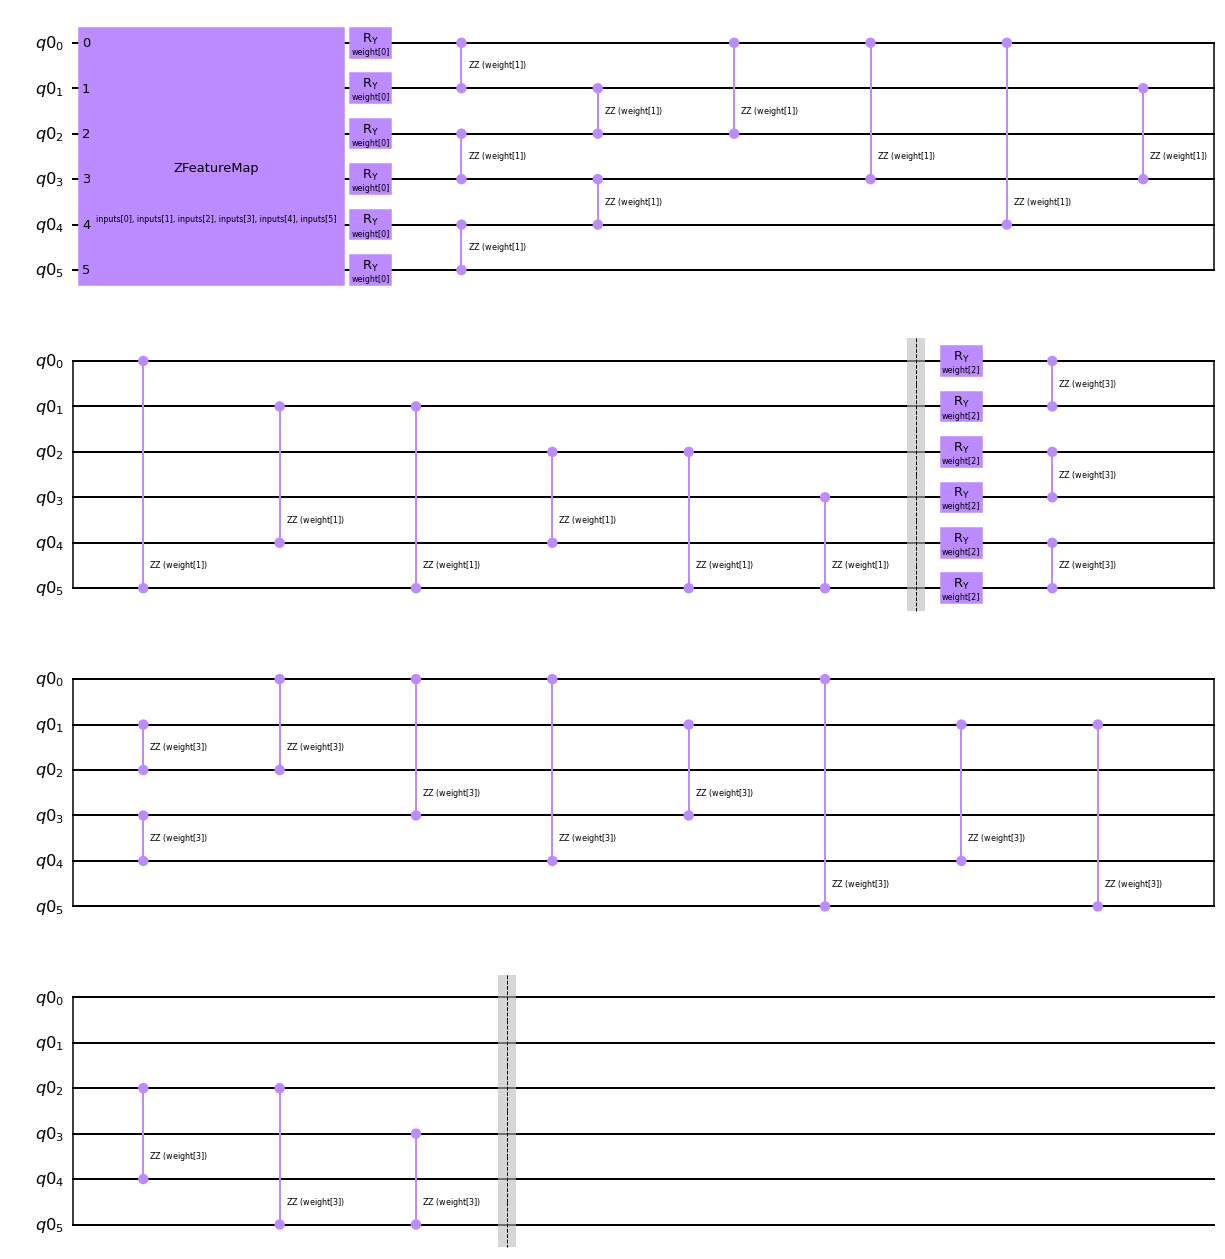

In [21]:
estimator_qnn_rotPerm1.circuit.draw('mpl')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


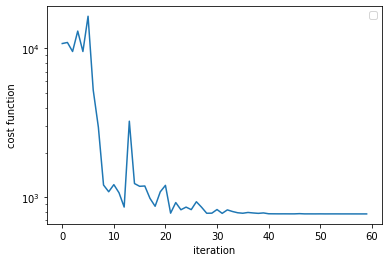

In [22]:

initial_weights=np.pi*2*np.random.rand(estimator_qnn_rotPerm1.num_weights+1)
cost_val_list=[]

res_rotPerm1 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_qnn_rotPerm1,X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])) #minimize cost function via scipy
cost_val_list_rotPerm1=cost_val_list
params_rotPerm1=res_rotPerm1.x

In [23]:
yyy=estimator_qnn_rotPerm1.forward(X_train_dot[0:maxEvents],params_rotPerm1[0:-1]).flatten()
yy=-abs(yyy-params_rotPerm1[-1])

<Figure size 432x288 with 0 Axes>

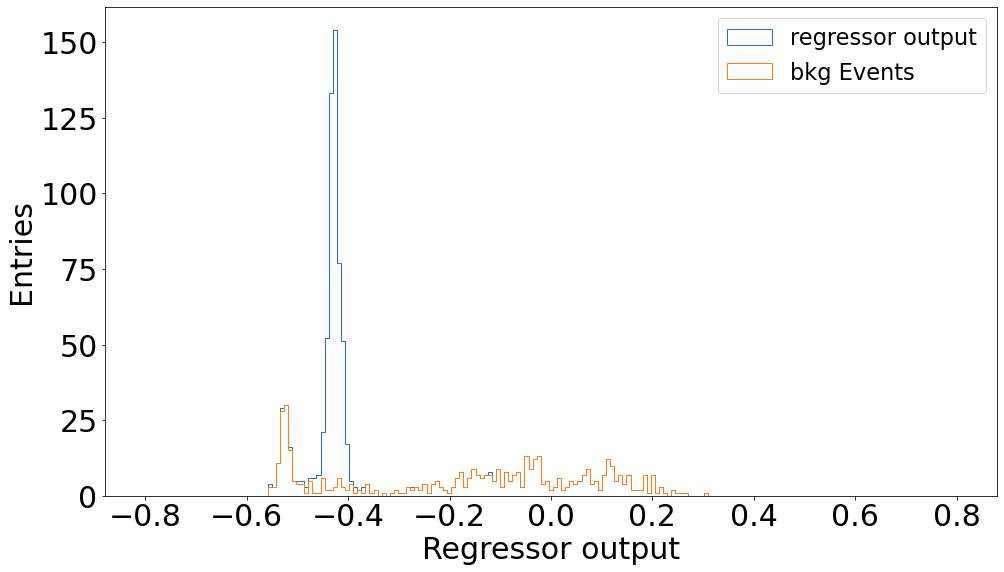

In [24]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
#bins=np.linspace(-0,0.1,100)

plt.hist(yyy,bins=bins,histtype='step',label='regressor output')
plt.hist(yyy[y_train_dot[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')


plt.xlabel('Regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

<Figure size 432x288 with 0 Axes>

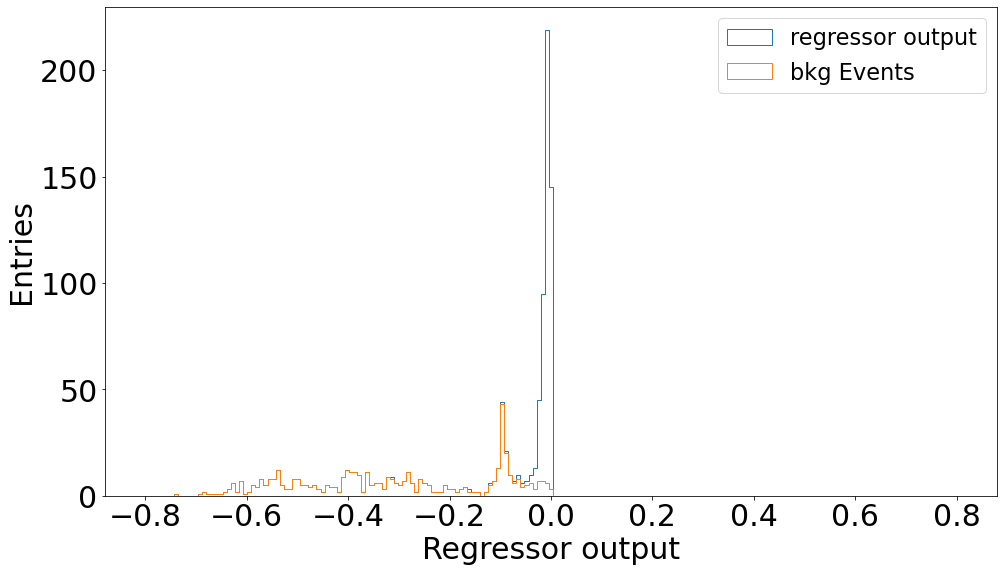

In [25]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
#bins=np.linspace(-0,0.1,100)

plt.hist(yy,bins=bins,histtype='step',label='regressor output')
plt.hist(yy[y_train_dot[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')


plt.xlabel('Regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

In [26]:
y_predict=yy
fpr, tpr, thresholds = metrics.roc_curve(y_train_dot[0:maxEvents], yy, pos_label=1)

bestValidation=0
threshold_best=0
for t in thresholds:
    y=y_predict.copy().flatten()
    y[y>t]=1
    y[y<t]=-1
    diff=y-y_train_dot[0:maxEvents]
    val=diff[diff==0].shape[0]/y.shape[0]
    if val>bestValidation:
        bestValidation=val
        threshold_best=t
        print(val,threshold_best)

0.493 inf
0.53 -0.001379670636853958
0.557 -0.0022005599517453955
0.602 -0.0033447068601788477
0.72 -0.006378432507941345
0.743 -0.007135922676356599
0.8 -0.009456205974203935
0.827 -0.010763038243558065
0.828 -0.011184460230352244
0.841 -0.012288546895990626
0.855 -0.013509391807204285
0.881 -0.015617178639524831
0.884 -0.016393628284217143
0.909 -0.018440232679735602
0.918 -0.019496607428940604
0.923 -0.020634221337209657
0.929 -0.0217852670658627
0.931 -0.0226058201826288
0.95 -0.027347789705973125
0.952 -0.028406574154650255
0.955 -0.03502891470182673
0.957 -0.03604726282755866


In [27]:
y_predict_test=estimator_qnn_rotPerm1.forward(X_test_dot[0:maxEvents],params_rotPerm1[0:-1]).flatten()
y_predict_test=-abs(y_predict_test-params_rotPerm1[-1])
y_predict_test[y_predict_test<threshold_best]=-1
y_predict_test[y_predict_test>=threshold_best]=1
diff=y_predict_test-y_test_dot[0:maxEvents]
acc=diff[diff==0].shape[0]/diff.shape[0]
print(acc)


0.968


In [28]:
y_test_rotPerm=estimator_qnn_rotPerm1.forward(X_test_dot[0:maxEvents],params_rotPerm1[0:-1]).flatten()
y_test_rotPerm=-abs(y_test_rotPerm-params_rotPerm1[-1])
fpr_rotPerm, tpr_rotPerm, thresholds_rotPerm = metrics.roc_curve(y_test_dot[0:maxEvents], y_test_rotPerm, pos_label=1)
print("AUC = ",metrics.auc(fpr_rotPerm, tpr_rotPerm))

AUC =  0.9857234860454976


In [29]:
np.save("Lorentz_dataset/tpr_rotPerm_{}".format(Iter),tpr_rotPerm)
np.save("Lorentz_dataset/fpr_rotPerm_{}".format(Iter),fpr_rotPerm)
np.save("Lorentz_dataset/cost_val_list_rotPerm_{}".format(Iter),np.array(cost_val_list_rotPerm1))


Rotation only

In [30]:
def getEstimator_baseline(num_layers,num_qubits):

    qr = QuantumRegister(num_qubits)
    qc = QuantumCircuit(qr)

    feature_map = ZFeatureMap(feature_dimension=num_qubits,reps=1,parameter_prefix="inputs")
    ansatz=RealAmplitudes(num_qubits, reps=num_layers)

    qc.compose(feature_map, inplace=True) 
    qc.compose(ansatz,inplace=True)  

    observable1 = SparsePauliOp.from_list([("Z" * num_qubits, 1)])
    estimator_qnn= EstimatorQNN(
        circuit=qc, observables=observable1, input_params=feature_map.parameters, weight_params=ansatz.parameters
    )
    print("nQubits = ",num_qubits)
    print("Depth of circuit is: ",qc.depth())
    return estimator_qnn

In [31]:
method='COBYLA'
maxEvents=1000

num_qubits=X_train_dot.shape[1]
estimator_rot=getEstimator_baseline(2,num_qubits)

nQubits =  6
Depth of circuit is:  2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


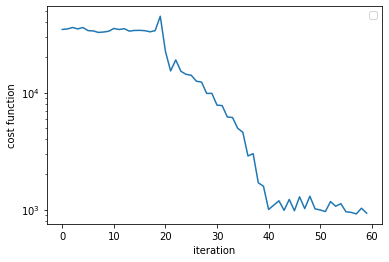

In [32]:

initial_weights=np.pi*2*np.random.rand(estimator_rot.num_weights+1)
cost_val_list=[]
res_rot = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_rot,X_train_dot[0:maxEvents], y_train_dot[0:maxEvents])) #minimize cost function via scipy
cost_val_list_rot=cost_val_list
params_rot=res_rot.x

In [33]:
y_test_rot=estimator_rot.forward(X_test_dot[0:maxEvents],params_rot[0:-1]).flatten()
y_test_rot=-abs(y_test_rot-params_rot[-1])
fpr_rot, tpr_rot, thresholds_rot = metrics.roc_curve(y_test_dot[0:maxEvents], y_test_rot, pos_label=1)
print("AUC = ",metrics.auc(fpr_rot, tpr_rot))

AUC =  0.783560208167494


<Figure size 432x288 with 0 Axes>

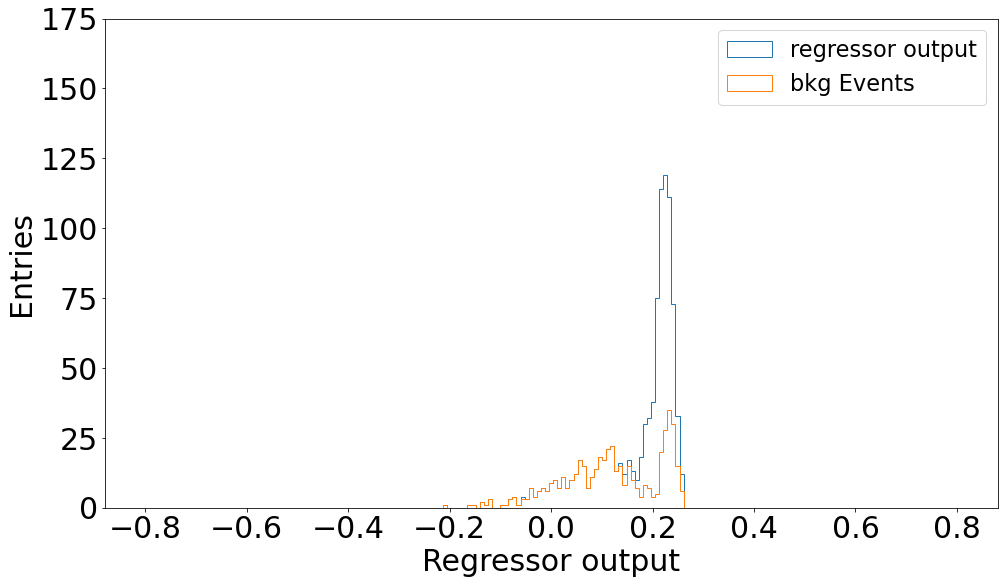

In [34]:
yyy=estimator_rot.forward(X_train_dot[0:maxEvents],params_rot[0:-1]).flatten()
yy=-abs(yyy-params_rot[-1])


plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
#bins=np.linspace(-0,0.1,100)
Max=175
plt.hist(yyy,bins=bins,histtype='step',label='regressor output')
plt.hist(yyy[y_train_dot[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')

plt.ylim(0,Max)
plt.xlabel('Regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

<Figure size 432x288 with 0 Axes>

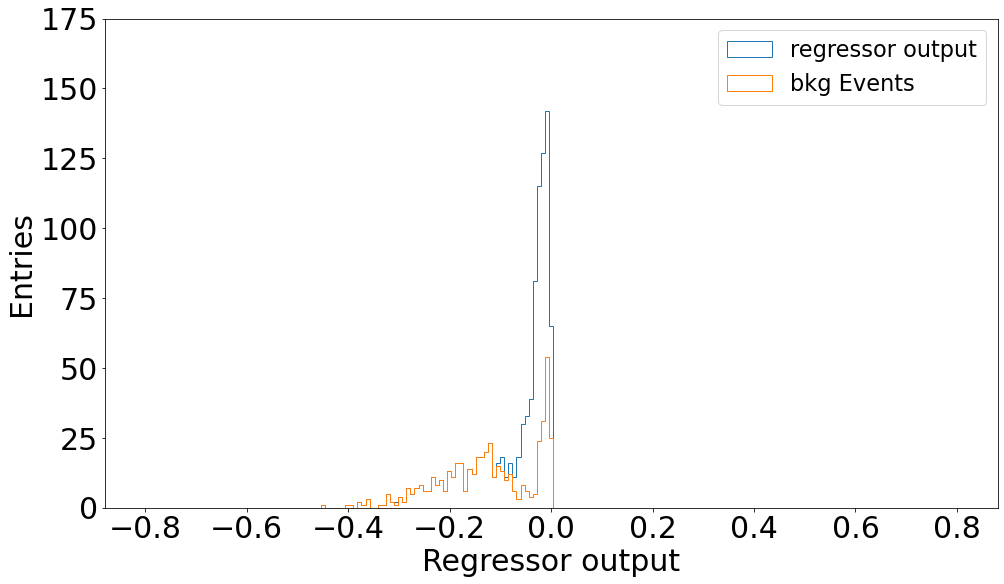

In [35]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
#bins=np.linspace(-0,0.1,100)
Max=175
plt.hist(yy,bins=bins,histtype='step',label='regressor output')
plt.hist(yy[y_train_dot[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')

plt.ylim(0,Max)
plt.xlabel('Regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

In [36]:
np.save("Lorentz_dataset/tpr_rot_{}".format(Iter),tpr_rot)
np.save("Lorentz_dataset/fpr_rot_{}".format(Iter),fpr_rot)
np.save("Lorentz_dataset/cost_val_list_rot_{}".format(Iter),np.array(cost_val_list_rot))


In [37]:


num_qubits=X_4.shape[1]
estimator_baseline1=getEstimator_baseline(2,num_qubits)

nQubits =  16
Depth of circuit is:  2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


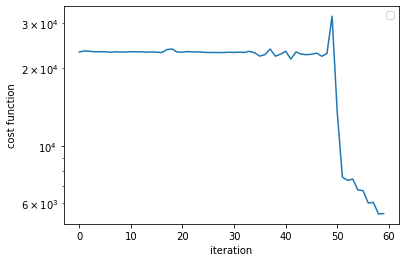

In [38]:

initial_weights=np.pi*2*np.random.rand(estimator_baseline1.num_weights+1)
cost_val_list=[]

res_baseline1 = scipy.optimize.minimize(cost_func, initial_weights,method=method,options={'maxiter':MaxIter}
                              ,args=(estimator_baseline1,X_train_4[0:maxEvents], y_train_4[0:maxEvents])) #minimize cost function via scipy
cost_val_list_baseline1=cost_val_list
params_baseline1=res_baseline1.x

In [39]:
yy=estimator_baseline1.forward(X_train_4[0:maxEvents],params_baseline1[0:-1]).flatten()
yy=-abs(yy-params_baseline1[-1])

<Figure size 432x288 with 0 Axes>

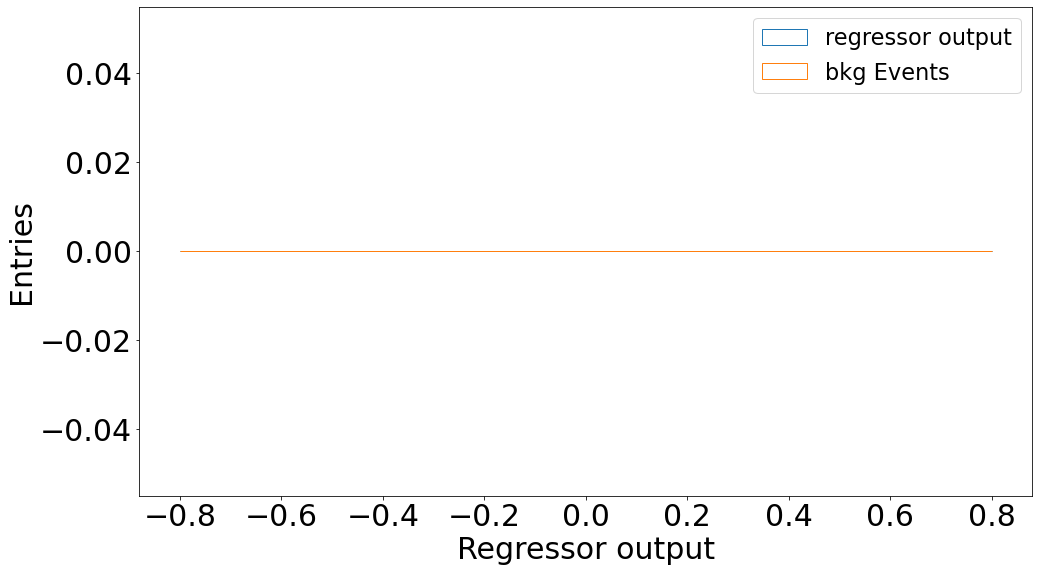

In [40]:
plt.figure(1)
LabelSize=30
plt.figure(figsize=(16,9))
bins=np.linspace(-0.8,0.8,200)
#bins=np.linspace(-0,0.1,100)

plt.hist(yy,bins=bins,histtype='step',label='regressor output')
plt.hist(yy[y_train_4[0:maxEvents]==-1],bins=bins,histtype='step',label='bkg Events')
#plt.plot([threshold_best_rotPerm1]*Max,np.arange(0,Max,1),label='cut')


plt.xlabel('Regressor output',fontsize=LabelSize)
plt.ylabel('Entries',fontsize=LabelSize)
plt.tick_params(axis='both', which='major', labelsize=LabelSize)
plt.legend(fontsize=LabelSize*0.75)

In [41]:

y_test_baseline=estimator_baseline1.forward(X_test_4[0:maxEvents],params_baseline1[0:-1]).flatten()
y_test_baseline=-abs(y_test_baseline-params_baseline1[-1])
fpr_baseline, tpr_baseline, thresholds_baseline = metrics.roc_curve(y_test_4[0:maxEvents], y_test_baseline, pos_label=1)
print(metrics.auc(fpr_baseline, tpr_baseline))

0.5731886347908525


In [42]:
np.save("Lorentz_dataset/tpr_baseline_{}".format(Iter),tpr_baseline)
np.save("Lorentz_dataset/fpr_baseline_{}".format(Iter),fpr_baseline)
np.save("Lorentz_dataset/cost_val_list_baseline_{}".format(Iter),np.array(cost_val_list_baseline1))


In [43]:
0.25*np.array(cost_val_list_baseline1)/maxEvents

array([5.79048272, 5.85028006, 5.82908736, 5.80463457, 5.80612453,
       5.80439462, 5.78075937, 5.80138147, 5.79100238, 5.79023977,
       5.80945126, 5.80005217, 5.80486973, 5.7832485 , 5.79518408,
       5.78187684, 5.76620456, 5.92136691, 5.94749579, 5.78848046,
       5.78272012, 5.81424425, 5.79763922, 5.79564367, 5.78148191,
       5.76676566, 5.76523151, 5.7653905 , 5.76448084, 5.7806584 ,
       5.77012456, 5.78280789, 5.76753383, 5.82680607, 5.74615279,
       5.58190134, 5.65984696, 5.94791976, 5.58034901, 5.6804847 ,
       5.83201312, 5.43854478, 5.7944176 , 5.68419032, 5.65417147,
       5.67564399, 5.73438782, 5.57597447, 5.71057916, 7.96891233,
       3.38750033, 1.89715513, 1.8427941 , 1.86421198, 1.69183827,
       1.68129761, 1.5067065 , 1.51266589, 1.36564702, 1.37005648])

massCut

In [44]:
def getROC(X_mass,y_mass):
    window_size=np.linspace(0.1,1000,5000)
    pred=np.ones_like(y_mass)*(-1)
    tpr_list=[]
    fpr_list=[]
    for size in window_size:
        pred[abs(X_mass-125)<size]=1
        tpr=pred[(pred==1)&(y_mass==1)].shape[0]/y_mass[y_mass==1].shape[0]
        fpr=pred[(pred==1)&(y_mass==-1)].shape[0]/y_mass[y_mass==-1].shape[0]
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list,fpr_list

In [45]:
tpr_mass,fpr_mass=getROC(X_test_mass,y_test_mass)

In [46]:
np.save("Lorentz_dataset/tpr_maxx_{}".format(Iter),tpr_mass)
np.save("Lorentz_dataset/fpr_maxx_{}".format(Iter),fpr_mass)

In [47]:
metrics.auc(fpr_mass,tpr_mass)

0.9869416735418385